In [2]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  
from GPyOpt.methods import BayesianOptimization

Neural Network Model for Hyper Parameter Tuning

In [3]:
def benchmark(X, Y):
    return (X * np.sin(X)) + (Y * np.sin(Y))


In [4]:
# Random seed
np.random.seed(1)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 10

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [5]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, y, a, b: 0.1 * (a - 4) * x + 0.05 * (b + 3) * y**2 + 0.03 * x * y + r.normal(0, sim_stdev)

In [6]:
# Generate 10 random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(-5, 18, pretrain_n)
Y = np.random.uniform(-5, 18, pretrain_n)

# Calculate the outputs using Himmelblau's Function
output1 = benchmark(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset of Physical Experiments
df = pd.DataFrame({
    'x': X,
    'y': Y,
    'z': output1,
})


In [7]:
sim_eval = lambda x, y, a, b: benchmark(x, y) + sim_err(x, y, a, b)

In [8]:
df

,x,y,z
0,4.591506,4.641474,-9.178355
1,11.567463,10.760049,-20.215970
2,-4.997369,-0.297598,-4.729201
3,1.953649,15.196701,9.125555
4,-1.624615,-4.370085,-2.404303
5,-2.876212,10.420753,-7.934456
6,-0.716015,4.598010,-4.114257
7,2.947897,7.849866,8.455922
8,4.125652,-1.771100,-1.685894
9,7.392785,-0.443666,6.783145


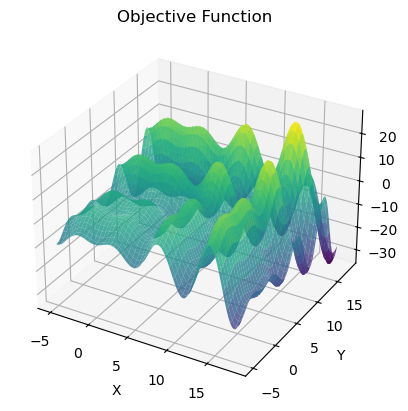

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the grid of input values
x_range = np.linspace(-5, 18, 100)
y_range = np.linspace(-5, 18, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Evaluate function on grid
z_grid = benchmark(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Objective Function')

# Show the plot
plt.show()

In [10]:
# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [11]:
# Define the known global maxima for the Himmelblau's function
global_maxima_points = [
    {"X": 14.28, "Y":  14.28, "Z": benchmark(14.28,  14.28)},
]

# Create a DataFrame for the global maxima
global_maxima_df = pd.DataFrame(global_maxima_points)
global_maxima_df

,X,Y,Z
0,14.28,14.28,28.269165


In [12]:
def perform_iteration(df):

    def sim_all(x):
        df["a"] = x[0,0]
        df["b"] = x[0,1]
        df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
        df["diff"] = df["z"] - df["sim_z"]
        return (df["diff"]**2).sum()

    bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
            {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

    # Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
    bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
    bo.run_optimization(max_iter=max_bo_iter)
    df["a"] = bo.x_opt[0]
    df["b"] = bo.x_opt[1]
    print(bo.x_opt)

    # Create the grid of input values
    x_range = np.linspace(-5, 18, 100)
    y_range = np.linspace(-5, 18, 100)
    x_grid, y_grid = np.meshgrid(x_range, y_range)
    sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

    # Create the plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

    # Customize the plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('True Function with Simulation Calibrated Errors')

    # Show the plot
    plt.show()

    # Generate 15 points using Latin Hypercube Sampling (LHS)
    n_samples = 90
    lhs= qmc.LatinHypercube(d=2, optimization="random-cd")
    lhs_samples = lhs.random(n=n_samples)
    bounds = np.array([[-5, 18], [-5, 18]])  # Bounds for Design Space

    scaled_samples = qmc.scale(lhs_samples, bounds[:, 0], bounds[:, 1])

    selected_points_df = pd.DataFrame(scaled_samples, columns=['x', 'y'])
    selected_points_df['sim_z'] = sim_eval(selected_points_df['x'], selected_points_df['y'], bo.x_opt[0], bo.x_opt[1])

    sim_df = df[["x", "y", "sim_z"]]
    sim_df = pd.concat([sim_df, selected_points_df], axis=0, ignore_index=True)
    
    # Define the objective function to minimize
    @use_named_args(hyp_space)
    def objective(**params):
        num_layers = params['num_layers']
        num_units = params['num_units']
        learning_rate = params['learning_rate']
        dropout_rate = params['dropout_rate']
        batch_size = params['batch_size']
        epochs = params['epochs']

        model = NN_model(num_layers, num_units, learning_rate, dropout_rate)
    
        # Define K-fold cross-validation
        kfold = KFold(n_splits=5, shuffle=True, random_state=0)
        scores = []

        # Perform cross-validation
        for train_idx, val_idx in kfold.split(df[['x', 'y']]):
            X_train, X_val = df[['x', 'y']].iloc[train_idx], df[['x', 'y']].iloc[val_idx]
            y_train, y_val = df[['sim_z']].iloc[train_idx], df[['sim_z']].iloc[val_idx]

            # Standardize the features
            scaler_x = StandardScaler().fit(X_train)
            X_train_scaled = scaler_x.transform(X_train)
            X_val_scaled = scaler_x.transform(X_val)

            # Train the model
            model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_scaled, y_val))

            # Evaluate the model
            score = model.evaluate(X_val_scaled, y_val, verbose=0)
            scores.append(score)
    
        return np.mean(scores)

    # Perform Bayesian optimization
    result = gp_minimize(objective, hyp_space, n_calls=50, random_state=0, acq_func='EI')

    # Output best hyperparameters from BayesOpt
    print("Best hyperparameters:")
    print("num_layers:", result.x[0])
    print("num_units:", result.x[1])
    print("learning_rate:", result.x[2])
    print("dropout_rate:", result.x[3])
    print("batch_size:", result.x[4])
    print("epochs:", result.x[5])

    # Train the model with the best hyperparameters on the entire dataset
    best_model = NN_model(
        num_layers=result.x[0],
        num_units=result.x[1],
        learning_rate=result.x[2],
        dropout_rate=result.x[3]
    )

    # Standardize the Dataset of Simulation Responses
    scaler = StandardScaler().fit(sim_df[['x', 'y']])
    X_scaled = scaler.transform(sim_df[['x', 'y']])

    # Train the best model on the combined standardized dataset
    best_model.fit(X_scaled, sim_df[['sim_z']], epochs=result.x[5], batch_size=result.x[4], verbose=1)

    # Create a meshgrid and combine into a single array
    xy_grid = np.c_[x_grid.ravel(), y_grid.ravel()]

    # Perform MC Dropout predictions on the entire grid
    xy_grid_scaled = scaler.transform(xy_grid)
    pred_mean, pred_std = mc_dropout_predictions(best_model, xy_grid_scaled)

    # Ploting mean predictions and confidence intervals
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Reshaping predictions back to grid shape
    pred_mean_grid = pred_mean.reshape(x_grid.shape)
    pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x_grid.shape)
    pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x_grid.shape)

    mean_surface = ax.plot_surface(x_grid, y_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
    upper_surface = ax.plot_surface(x_grid, y_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
    lower_surface = ax.plot_surface(x_grid, y_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

    # Customize the plot
    ax.set_title('Neural Network of Simulated Response with Confidence Intervals')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')

    # Legend
    legend_elements = [mean_surface, upper_surface, lower_surface]
    fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

    # Show the plot
    plt.show()
    
    x_range = [(-5, 18)]
    y_range = [(-5, 18)]
    def p_nn(xy):
        xy = np.array(xy).reshape(1, -1)  # Ensure correct shape (1,2)
        xy_scaled = scaler.transform(xy)
        pred_mean, pred_std = mc_dropout_predictions(best_model, xy_scaled)
        # Check if the point is inside the valid domain
        if (x_range[0][0] <= xy[0, 0] <= x_range[0][1] and 
                y_range[0][0] <= xy[0, 1] <= y_range[0][1]):
            
            probability = max(pred_mean + 1.96 * pred_std - sim_df["sim_z"].median(), 1e-6)  # Avoid zero
            return probability
        else:
            return 1e-10  # Keep very small but nonzero probability for out-of-bounds case


    def metropolis_step(xy, sig):
        prop_xy = xy + np.random.normal(0, sig, size=xy.shape)  # Generate a candidate

        # Ensure proposed point is inside the valid bounds
        if not (x_range[0][0] <= prop_xy[0, 0] <= x_range[0][1] and 
                y_range[0][0] <= prop_xy[0, 1] <= y_range[0][1]):
            return xy  # Reject out-of-bounds proposals

        u = np.random.uniform(0, 1)
        if u < min(1.0, p_nn(prop_xy) / p_nn(xy)):
            return prop_xy  # Accept move
        else:
            return xy  # Stay at current point


    def mh_sampler(sig, sample_size, burn_in, lag):
        # Start at the point with the largest simulated response
        max_idx = np.argmax(sim_df["sim_z"])
        x_init = sim_df["x"].iloc[max_idx]
        y_init = sim_df["y"].iloc[max_idx]
        xy = np.array([[x_init, y_init]])

        # Burn-in phase
        for i in range(burn_in):
            xy = metropolis_step(xy, sig)

        # Sampling phase
        output = xy
        for i in range(sample_size - 1):
            for j in range(lag):
                xy = metropolis_step(xy, sig)
            output = np.vstack((output, xy))  # Stack valid samples

        return output  # Returns an array of shape (sample_size, 2)

    max_idx = np.argmax(sim_df["sim_z"])
    x_max = sim_df["x"].iloc[max_idx]
    y_max = sim_df["y"].iloc[max_idx]
    max_point = np.array([[x_max, y_max]])


    X_mh = mh_sampler(sig=5, sample_size=pretrain_n - 1, burn_in=50, lag=20)

    X_all = np.vstack([max_point, X_mh])

    physical_test_points = pd.DataFrame(X_all, columns=["x", "y"])

    # Generate predictions for the heatmap
    pred_mean_grid = pred_mean.reshape(x_grid.shape)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    heatmap = plt.contourf(x_grid, y_grid, pred_mean_grid, cmap='viridis', levels=50)
    plt.colorbar(heatmap, label="Neural Network Response")

    # Overlay sampled points
    plt.scatter(sim_df['x'], sim_df['y'], color='white', edgecolor='black', label='Simulation Sampled Points')
    plt.scatter(physical_test_points['x'], physical_test_points['y'], color='purple', edgecolor='black', label='Next Physical Test Points')

    # Customize the plot
    plt.title("Heatmap of Neural Network Response")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()

    # Add validated data points to original data frame
    physical_test_points["z"] = benchmark(physical_test_points['x'], physical_test_points['y']) + ran_err(pretrain_n, 0.05)
    physical_test_points["a"] = bo.x_opt[0]
    physical_test_points["b"] = bo.x_opt[1]
    physical_test_points["sim_z"] = sim_eval(physical_test_points["x"], physical_test_points["y"], physical_test_points["a"], physical_test_points["b"])
    physical_test_points["diff"] = physical_test_points["z"] - physical_test_points["sim_z"]

    # Heatmap of Simulated Points 
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot the heatmap for sim_z_grid
    heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

    # Overlay scatter points for sampling points
    ax.scatter(df["x"], df["y"], color='blue', marker='o', label='Previous Sampled Points')
    ax.scatter(sim_df["x"], sim_df["y"], edgecolor='black', facecolors='none', marker='o', label='Sampled Simulation Points')
    ax.scatter(physical_test_points["x"], physical_test_points["y"], color='purple', marker='o', label='Next Physical Test Points')

    # Overlay scatter points for global maxima
    ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Point')

    # Customize the plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
    ax.legend()

    # Add a color bar
    cbar = plt.colorbar(heatmap, ax=ax)
    cbar.set_label('Function Value (Z)')

    # Show the plot
    plt.show()

    # Add points to original dataframe
    df = pd.concat([df, physical_test_points], axis=0, ignore_index=True)

    return df

[ 2.73047019 -3.09689622]


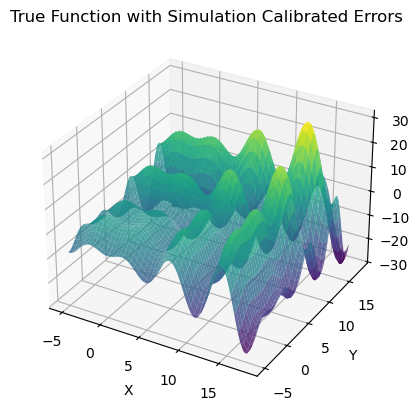

Best hyperparameters:
num_layers: 10
num_units: 162
learning_rate: 0.00011042858573520653
dropout_rate: 0.0
batch_size: 138
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 108.1543
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 108.1065
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 108.0596
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 108.0136
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 107.9675
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 107.9216
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 107.8757
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 107.8296
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 107.7832
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 107.7363
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 107.6891
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 107.6415
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 

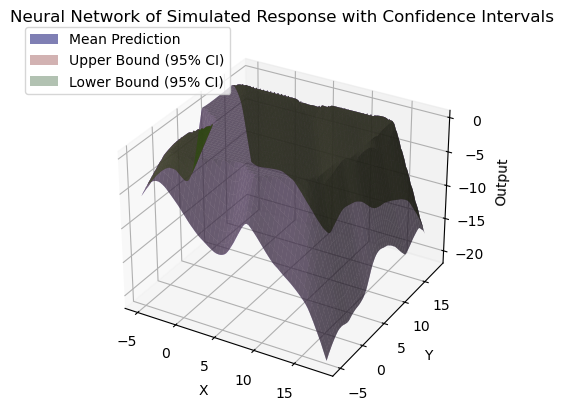

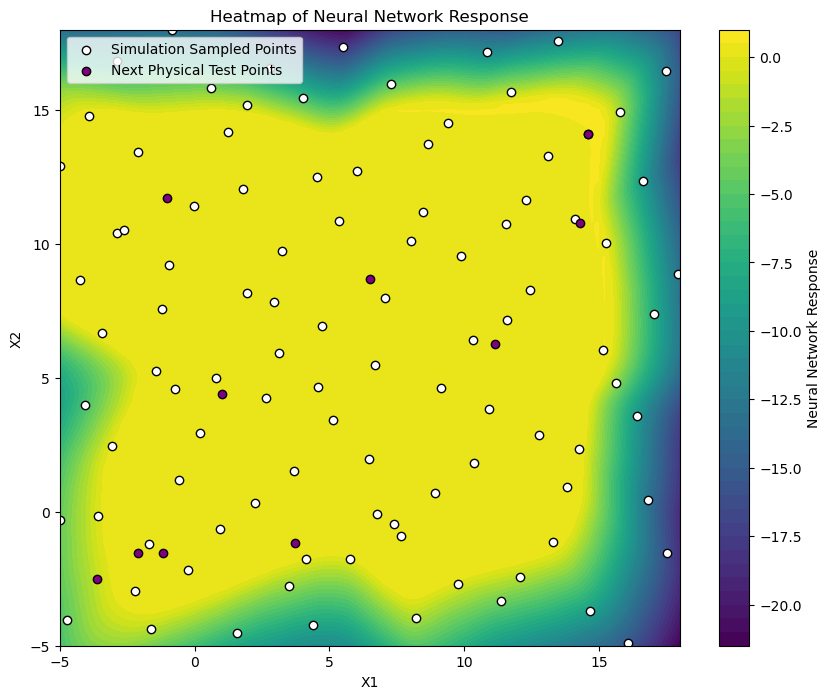

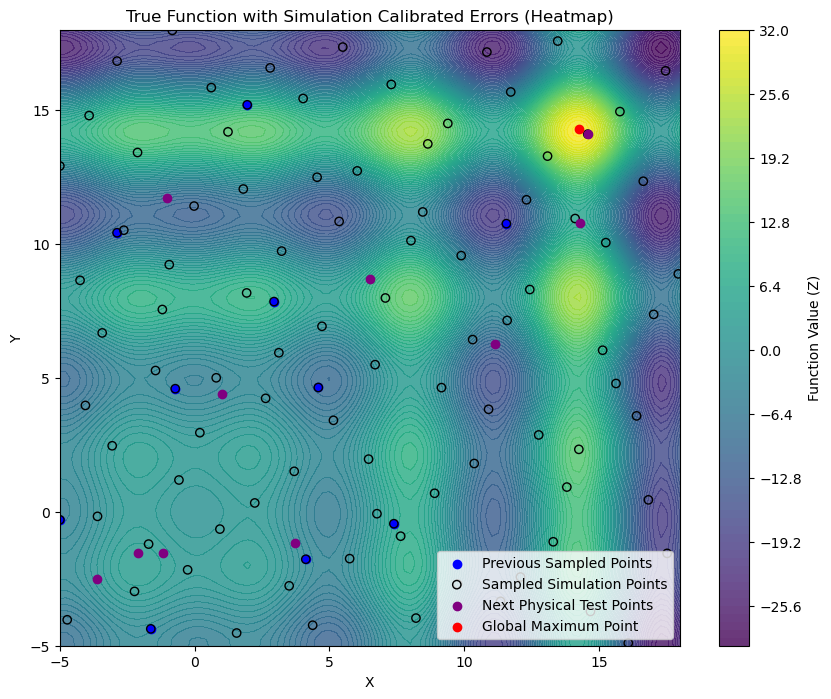

            x          y          z        a         b      sim_z      diff
0    4.591506   4.641474  -9.178355  2.73047 -3.096896  -9.561388  0.383033
1   11.567463  10.760049 -20.215970  2.73047 -3.096896 -18.981988 -1.233982
2   -4.997369  -0.297598  -4.729201  2.73047 -3.096896  -3.511473 -1.217728
3    1.953649  15.196701   9.125555  2.73047 -3.096896   9.891099 -0.765544
4   -1.624615  -4.370085  -2.404303  2.73047 -3.096896  -1.881428 -0.522875
5   -2.876212  10.420753  -7.934456  2.73047 -3.096896  -8.135435  0.200979
6   -0.716015   4.598010  -4.114257  2.73047 -3.096896  -4.002058 -0.112200
7    2.947897   7.849866   8.455922  2.73047 -3.096896   8.504247 -0.048325
8    4.125652  -1.771100  -1.685894  2.73047 -3.096896  -2.840597  1.154703
9    7.392785  -0.443666   6.783145  2.73047 -3.096896   5.045118  1.738027
10  14.585739  14.102660  27.284418  2.73047 -3.096896  30.595106 -3.310688
11   6.516606   8.677206   7.440016  2.73047 -3.096896   7.913350 -0.473334
12  14.28952

In [13]:
df = perform_iteration(df)
print(df)


[ 1.98152227 -3.14153877]


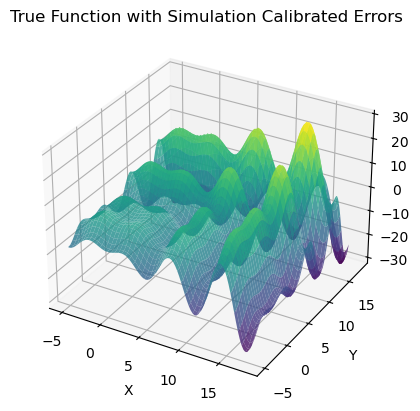

Best hyperparameters:
num_layers: 4
num_units: 59
learning_rate: 0.00012320410503562708
dropout_rate: 0.238832558660675
batch_size: 126
epochs: 122
Epoch 1/122
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 112.3614
Epoch 2/122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 113.0720
Epoch 3/122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 112.9342
Epoch 4/122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 112.8425
Epoch 5/122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 113.0278
Epoch 6/122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 112.8404
Epoch 7/122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 112.7679
Epoch 8/122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 112.8868
Epoch 9/122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 112.5856
Epoch 10/122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 112.8233
Epoch 11/122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 112.4478
Epoch 12/122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 112.5344
Epoch 13/122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/s

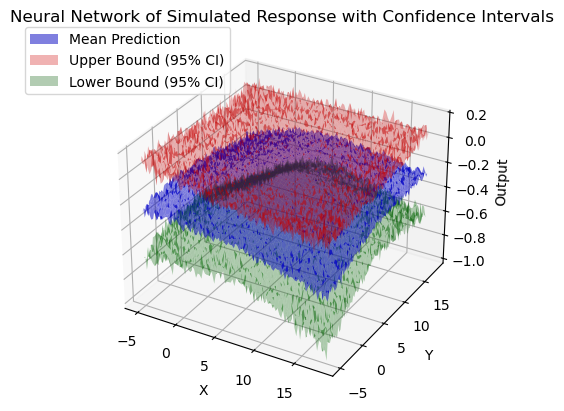

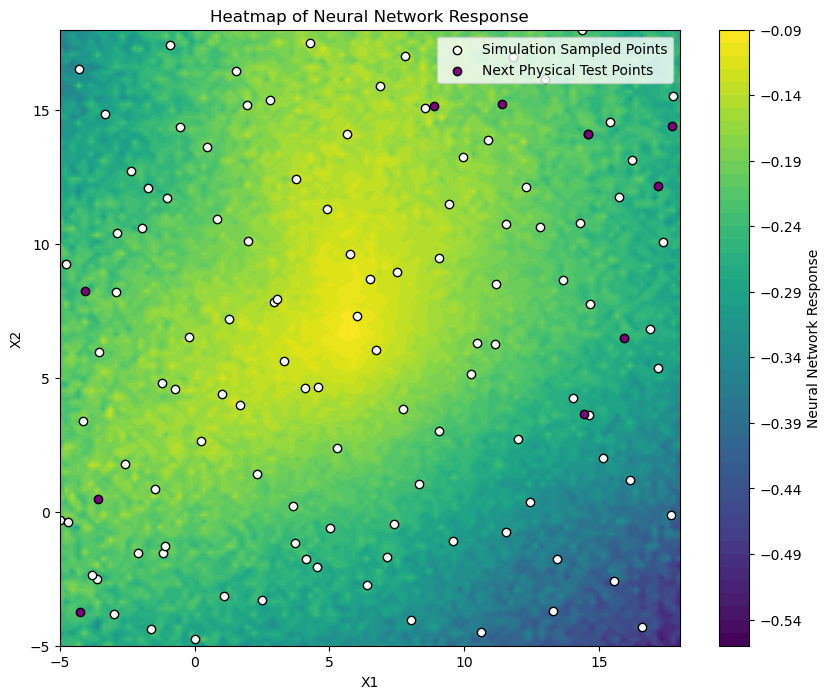

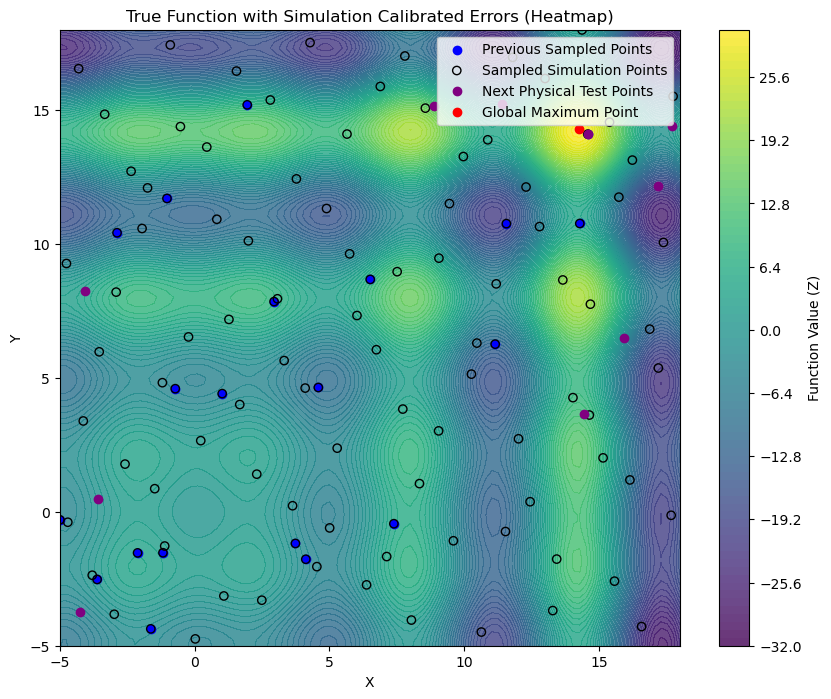

In [14]:
df = perform_iteration(df)

[ 1.71553153 -3.16909293]


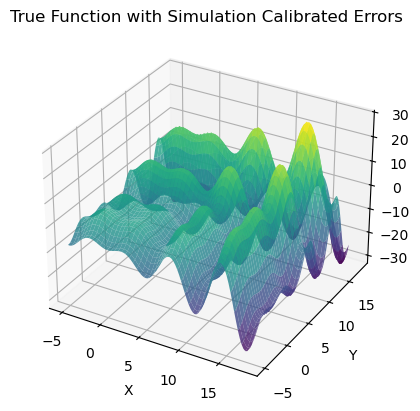

Best hyperparameters:
num_layers: 8
num_units: 200
learning_rate: 0.006533141015966463
dropout_rate: 0.0
batch_size: 150
epochs: 113
Epoch 1/113
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 114.4508
Epoch 2/113
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 111.4382
Epoch 3/113
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 112.9225
Epoch 4/113
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 107.6740
Epoch 5/113
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 108.0714
Epoch 6/113
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 107.5106
Epoch 7/113
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 106.6845
Epoch 8/113
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 105.7172
Epoch 9/113
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 104.4979
Epoch 10/113
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 102.8366
Epoch 11/113
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 101.6406
Epoch 12/113
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 99.9426
Epoch 13/113
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 99.0

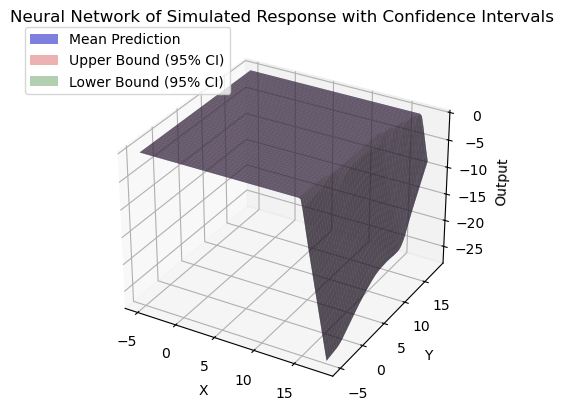

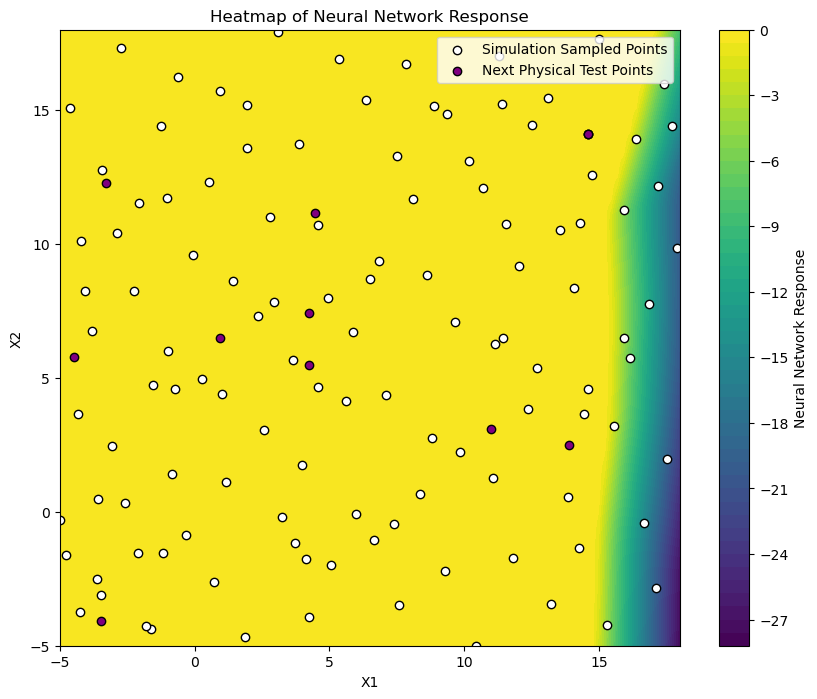

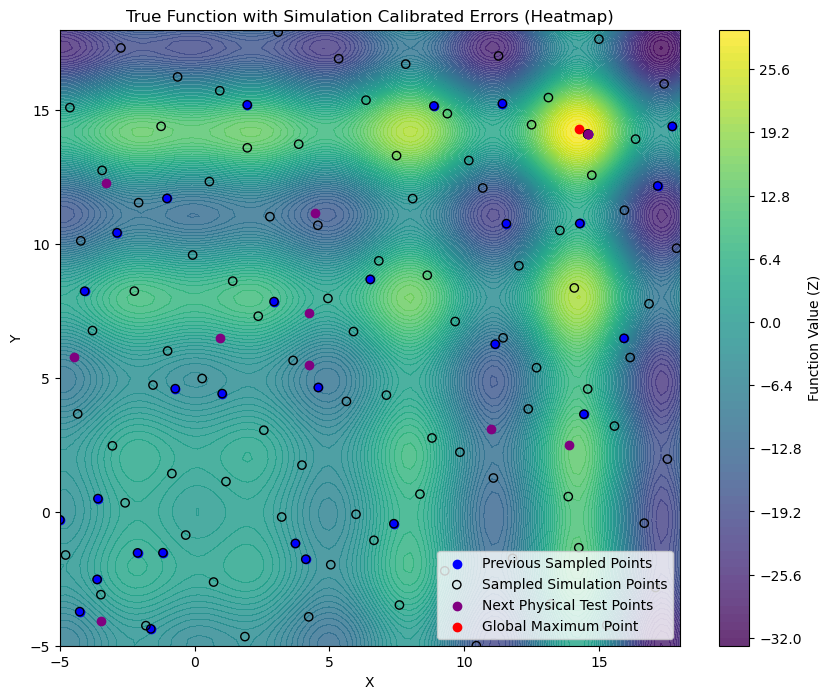

            x          y          z         a         b      sim_z      diff
0    4.591506   4.641474  -9.178355  1.715532 -3.169093  -9.552461  0.374106
1   11.567463  10.760049 -20.215970  1.715532 -3.169093 -19.508695 -0.707274
2   -4.997369  -0.297598  -4.729201  1.715532 -3.169093  -3.762137 -0.967065
3    1.953649  15.196701   9.125555  1.715532 -3.169093   7.844799  1.280756
4   -1.624615  -4.370085  -2.404303  1.715532 -3.169093  -2.146404 -0.257899
5   -2.876212  10.420753  -7.934456  1.715532 -3.169093  -9.284722  1.350266
6   -0.716015   4.598010  -4.114257  1.715532 -3.169093  -4.242538  0.128281
7    2.947897   7.849866   8.455922  1.715532 -3.169093   8.065512  0.390409
8    4.125652  -1.771100  -1.685894  1.715532 -3.169093  -2.684283  0.998390
9    7.392785  -0.443666   6.783145  1.715532 -3.169093   5.384326  1.398819
10  14.585739  14.102660  27.284418  1.715532 -3.169093  29.111955 -1.827537
11   6.516606   8.677206   7.440016  1.715532 -3.169093   7.299857  0.140160

In [15]:
df = perform_iteration(df)
print(df)